# Module 5 : Julie Vuadens et Hoa-Ai Béatrice Hua
## STOKES FLOW

Le but de ce module est de résoudre l'écoulement de Stokes dans une cavité de forme carré. Cet écoulement découle d'une simplification de l'équation de Navier-Stokes, en faisant l'hypothèse que le nombre de Reynold tend vers zéro.

Navier-Stokes : $\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho}\nabla p + \nu\nabla^2 u $

avec u et p la vitesse et la pression du fluide, respectivement, et $\nu$ la viscosité.

Il est possible de réécrire cette équation sans dimension en fonction de u et P seulement :

$Re \left(\frac{\partial u^*}{\partial t} + u^* \cdot \nabla u^* \right) = -\nabla p^* + \nabla^2 u^*$ où Re est le nombre de Reynolds tel que $Re<<1$. Ainsi on a  :

$-\nabla p + \nabla^2 u = 0$ <=> $ \nabla \times \left( - \nabla p + \nabla^2 u\right) = 0$

p est un scalaire donc $ \nabla \times (- \nabla p) = 0$

Finalement on a  $\nabla \times \nabla^2 u = \nabla^2 \omega $ avec $\omega$ définie comme la vorticité par $\nabla \times u = \omega$.

La vorticité est aussi appelée le vecteur tourbillon. Il caractérise en fait le mouvement de rotation autour d'un axe d'un flot.
En remaniant ces équations on obtient l'équation suivante : $$ \nabla ^2 \omega =0$$

En définissant la fonction de courant pour un écoulement $\psi$ par $u = \frac{\partial \psi}{\partial y}$ et $v = - \frac{\partial \psi}{\partial x}$ on obtient que $\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} = -\nabla ^2 \psi$

Finalement, il nous faut résoudre le système d'équations couplées :
$$ \nabla ^2 \omega =0$$
$$ \nabla ^2 \psi = -\omega $$

Pour cela, nous allons utiliser plusieurs méthodes et nous allons voir lesquelles sont les plus efficaces. Nous étudierons la méthode de l'itération de Jacobi, de Gauss-Seidel, SOR et steepest descent.

Commençons par importer toutes les librairies qui seront nécessaires et la résolution de notre problème.

In [1]:
import numpy
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
import numba
from numba import jit
import pylab

Les deux fonctions suivantes vont nous permettre respectivement de plotter en 3D les graphes de $\psi$ obtenu, et de tracer la colormap en 2D.

In [4]:
def plot_3D(x, y, p):
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$\psi$',fontsize=25)
    ax.set_title('$\psi$',fontsize=30)
    ax.view_init(30,45)

In [5]:
def plot_2D(psi):
    X,Y= pylab.meshgrid(x,y)
    pylab.xlabel('$x$')
    pylab.ylabel('$y$')
    pylab.title('$\psi$',fontsize=30)
    pylab.pcolor(X,Y,psi)
    pylab.colorbar()
    pylab.show()

Voici les paramètres du problème donnés dans les consignes :

In [6]:
nx = 41
ny = 41
l = 1.
h = 1.
dx = l/(nx-1)
dy = h/(ny-1)
l1_target = 1e-6
x=numpy.linspace(0,1,nx)
y=numpy.linspace(0,1,ny)

Cette fonction définie notre condition d'arrêt : lorsque la norme L1 de la différence entre deux itérations successives est inférieure à $10 ^{-6}$, on s'arrête là.

In [7]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Dans chacune des méthodes, il ne faut pas oublier d'imposer les conditions aux bords suivantes:

Top:

$\psi=0$

$\frac{\partial\psi}{\partial y}=1$

Bottom:

$\psi=0$

$\frac{\partial\psi}{\partial y}=0$

Right and left:

$\psi=0$

$\frac{\partial\psi}{\partial x}=0$

Notons que les conditions de Dirichlet sont automatiquement imposées, il suffit donc d'imposer celles de Neumann.

Les conditions de Neumann données sur $\psi$ impliquent les conditions sur $\omega$ suivantes:

Top:

$$\omega_{i,j}=-\frac{1}{2\Delta y^2} (8\psi_{i,j-1}-\psi_{i,j-2})-\frac{3u_{j}}{\Delta y}$$

Bottom:

$$\omega_{i,j}=-\frac{1}{2\Delta y^2} (8\psi_{i,j+1}-\psi_{i,j+2})$$

Left:


$$\omega_{i,j}=-\frac{1}{2\Delta x^2} (8\psi_{i+1,j}-\psi_{i+2,j})$$

Right:

$$\omega_{i,j}=-\frac{1}{2\Delta x^2} (8\psi_{i-1,j}-\psi_{i-2,j})$$

## I. Méthode de Jacobi

Cette méthode est la plus simple à effectuer et la plus intuitives surtout. Les valeurs à chaque point sont remplacée par leur moyenne pondérée correspondante.

$$\omega^{k+1}_{i,j} = \frac {1}{4} ( \omega^k_{i,j-1} + \omega^k_{i,j+1} + \omega^k_{i-1,j} + \omega^k_{i+1,j} )$$

$$ -\omega^k_{i,j} = \frac {\psi^k_{i,j+1} - 2\psi^{k+1}_{i,j} + \psi^k_{i,j-1}}{\Delta y ^2} + \frac {\psi^k_{i+1,j} - 2\psi^{k+1}_{i,j} + \psi^k_{i-1,j}}{\Delta x ^2}$$

$$ <=> \psi^{k+1}_{i,j} = \frac {1}{2(\Delta x ^2 + \Delta y ^2)} ((\psi^k_{i+1,j} + \psi^k_{i-1,j}) \Delta  y^2 + (\psi^k_{i,j+1} + \psi^k_{i,j-1}) \Delta  x^2 + \omega^k_{i,j} \Delta x^2 \Delta y^2) $$

In [8]:
def Jacobi_Stokes(w,psi):    
    L1_w = 1
    L1_psi = 1
    wn = numpy.empty_like(w)
    psin = numpy.empty_like(psi)
    iterations = 0
    
    while (L1_w>l1_target or L1_psi>l1_target) :
        wn = w.copy()
        psin = psi.copy()

        w[1:-1,1:-1] = .25 * (wn[1:-1,2:] + wn[1:-1,:-2] + wn[2:,1:-1] + wn[:-2,1:-1])

        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((psin[1:-1,2:]+psin[1:-1,:-2])*dy**2 +\
                        (psin[2:,1:-1] + psin[:-2,1:-1])*dx**2 + wn[1:-1,1:-1]*dx**2*dy**2)

        #Bound conditions
        w[:,-1] = -1./(2.*dx**2) * (8.*psi[:,-2] - psi[:,-3])               #right
        w[:,0] = -1./(2.*dx**2) * (8.*psi[:,1] - psi[:,2])                  #left
        w[0,:] = -1./(2.*dy**2) * (8.*psi[1,:] - psi[2,:])                  #bottom
        w[-1,:] = -1./(2.*dy**2) * (8.*psi[-2,:] - psi[-3,:]) - 3./dy       #top
        
        L1_w = L1norm(w,wn)
        L1_psi = L1norm(psi,psin)
        iterations += 1
    return psi,w,iterations

Ajouter %%timeit permet de mesurer combien de temps prend la méthode de Jacobi ici pour s'appliquer.

Remarque : on utilisera toujours les mêmes vorticité et fonction de courant initiales, que nous notons alors $\omega_0$ et $\psi _0$

In [9]:
w0 = numpy.zeros((nx,ny))
w0[-1,:] = -3/dy
psi0 = numpy.zeros((nx,ny))

In [10]:
%%timeit
Jacobi_Stokes(w0.copy(),psi0.copy())

1 loop, best of 3: 1.79 s per loop


Nombre d itérations pour la méthode de Jacobi : 4059


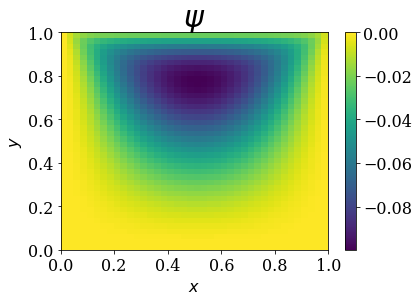

(None, None)

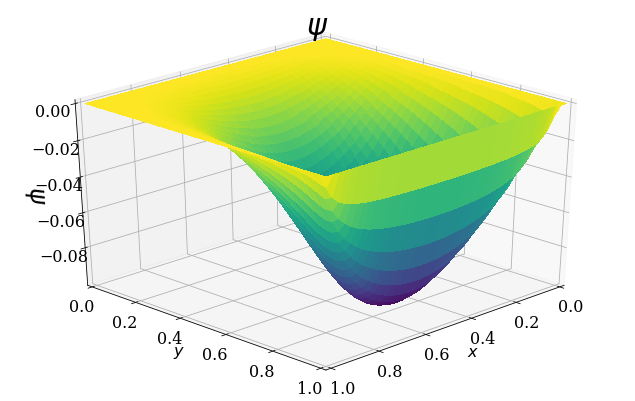

In [11]:
psi,w,iterations=Jacobi_Stokes(w0.copy(),psi0.copy())
print('Nombre d itérations pour la méthode de Jacobi : {0:d}'.format(iterations))
plot_2D(psi) , plot_3D(x,y,psi)

Il faut 4059 itérations pour obtenir le résultat à cette méthode et près de 400 ms, elle n'est donc pas très efficace. Vérifions qu'elle nous donne les bonnes valeurs de la vorticité et de la fonction de courant :

La valeur maximale de |$\psi$| est :

In [12]:
numpy.max(numpy.abs(psi[:]))

0.099845172462224338

La valeur maximale de |$\omega$| est :

In [13]:
numpy.max(numpy.abs(w[:]))

120.0

In [14]:
numpy.max(numpy.abs(w[:,1:-1]))

78.192661228600699

In [15]:
psi[32,::8]

array([ 0.        , -0.05747874, -0.09442319, -0.09442319, -0.05747874,  0.        ])

Donc la méthode de Jacobi nous donne la bonne solution de la fonction de courant $\psi$. 

## II.Méthode de Gauss Seidel

La méthode de Gauss Seidel est assez similaire à celle de Jacobi. La différence est qu'il faut désormais utiliser les nouvelles valeurs de la solution dès qu'elles sont disponibles. Il faudra alors utiliser $\omega^{k+1}_{i-1,j}$ et $\omega^{k+1}_{i,j-1}$ pour calculer $\omega^{k+1}_{i,j}$. Les itérations deviennent alors :

$$ \omega^{k+1}_{i,j} = \frac {1}{4} (\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j}) $$

$$ \psi^{k+1}_{i,j} = \frac {1}{2(\Delta x ^2 + \Delta y ^2)} ((\psi^k_{i+1,j} + \psi^k_{i-1,j}) \Delta  y^2 + (\psi^k_{i,j+1} + \psi^k_{i,j-1}) \Delta  x^2 + \omega^k_{i,j} \Delta x^2 \Delta y^2) $$

In [16]:
@jit
def Gauss_Seidel_Stokes(w,psi):   
    iterations = 0
    iter_diff_w = l1_target+1. #init iter_diff to be larger than l1_target
    iter_diff_psi = l1_target +1
    while iter_diff_w > l1_target or iter_diff_psi > l1_target :
        wn = w.copy()
        psin = psi.copy()
        iter_diff_w = 0.0
        iter_diff_psi = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (w[j,i-1] + w[j,i+1] + w[j-1,i] + w[j+1,i])
                psi[j,i] = 1./(2.*(dx**2 + dy**2)) * ((psi[j+1,i]+psi[j-1,i])*dy**2 +\
                                                      (psi[j,i+1] + psi[j,i-1])*dx**2 + w[j,i]*dx**2*dy**2)
                iter_diff_w += numpy.abs(w[j,i] - wn[j,i])
                iter_diff_psi += numpy.abs(psi[j,i] - psin[j,i])

        # Bound condition
        w[:,-1] = -1./(2.*dx**2) * (8.*psi[:,-2] - psi[:,-3])               #right
        w[:,0] = -1./(2.*dx**2) * (8.*psi[:,1] - psi[:,2])                  #left
        w[0,:] = -1./(2.*dy**2) * (8.*psi[1,:] - psi[2,:])                  #bottom
        w[-1,:] = -1./(2.*dy**2) * (8.*psi[-2,:] - psi[-3,:]) - 3./dy       #top       
        
        iterations += 1
    return psi,w,iterations

In [17]:
%%timeit
Gauss_Seidel_Stokes(w0.copy(),psi0.copy())

The slowest run took 41.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 89.2 ms per loop


Nombre d'itérations pour la méthode de Gauss-Seidel :4059


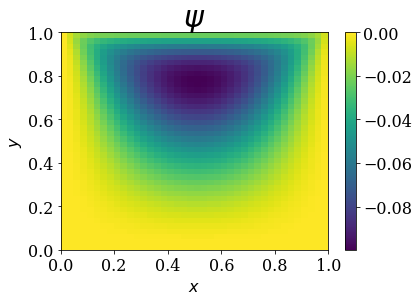

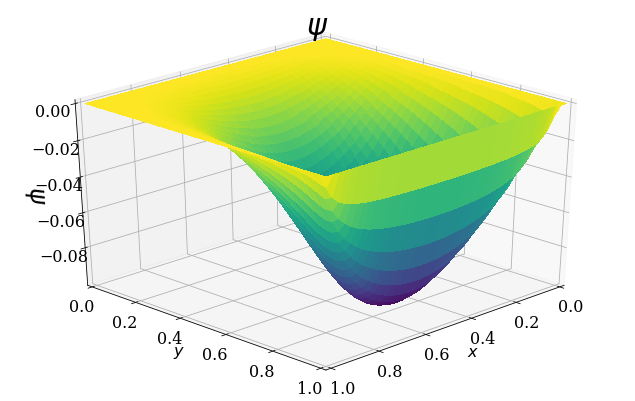

In [18]:
psi1,w1,iterations1 = Gauss_Seidel_Stokes(w0.copy(),psi0.copy())
print("Nombre d'itérations pour la méthode de Gauss-Seidel :{}".format(iterations))
plot_2D(psi1)
plot_3D(x,y,psi1)

Pour cette méthode, nous utilisons NUMBA et @jit, un optimisateur sur python qui permet d'accélérer le programme. Cela nous permet d'éxecuter la boucle en 36 ms, ce qui est bien plus rapide que dans le cas où l'on n'utilise pas numba. Le gain de temps ici est déjà important, mais numba se montrera encore plus utile dans les prochaines méthodes qui demandent des calculs plus rapides.

Nous observons aussi que le nombre d'itérations que Gauss Seidel doit faire pour arriver au critère de sortie $10^{-6}$ est environ divisé par deux, comparé à la méthode de Jacobi : 2118 itérations pour Gauss Seidel contre 4059 pour Jacobi. Elle est donc plus efficace.

Vérifions les résultats:

La valeur maximale de |$\psi$| est :

In [19]:
numpy.max(numpy.abs(psi1[:]))

0.099845170308277803

La valeur maximale de |$\omega$| est :

In [20]:
numpy.max(numpy.abs(w1[:]))

120.0

In [21]:
numpy.max(numpy.abs(w1[:,1:-1]))

78.192661227036723

In [22]:
psi1[32,::8]

array([ 0.        , -0.05747874, -0.09442318, -0.09442318, -0.05747874,  0.        ])

On obtient bien les bons résultats.

## III. Méthode de Stokes Successive Over-Relaxation

La méthode SOR (Successive over-relaxation) emploi une combinaison linéaire de la solution juste calculé et de la valeur précédente : $$\omega^{k+1}_{i,j} = (1 - w)\omega^k_{i,j} + \frac{w}{4} \left(\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j} \right)$$
$$ \psi^{k+1}_{i,j} = \frac {1}{2(\Delta x ^2 + \Delta y ^2)} ((\psi^k_{i+1,j} + \psi^k_{i-1,j}) \Delta  y^2 + (\psi^k_{i,j+1} + \psi^k_{i,j-1}) \Delta  x^2 + \omega^k_{i,j} \Delta x^2 \Delta y^2) $$


$\omega$ : le paramètre de relaxation, $0<w<2$ pour que la solution soit stable. Ici nous aimerions que $\omega$ soit le plus grand possible ( pour qu'il converge avec le moins d'itérations possible) tout en restant stable. Pour un domaine carré, une formule nous  est donnée pour un paramètre $\omega$ optimal : 
\begin{equation}
\omega \approx \frac{2}{1+\frac{\pi}{nx}}
\end{equation}

In [23]:
@jit
def Stokes_SOR(w,psi): 
    
    iterations = 0
    iter_diff_w = l1_target + 1 
    iter_diff_psi = l1_target + 1 
    
    denominator = 0.0
    nx,ny = w.shape
    omega = 2./(1 + numpy.pi/nx)
    
    l1_diff_w = numpy.zeros(20000)
    l1_diff_psi = numpy.zeros(20000)
    
    wn = w.copy()
    psin=psi.copy()

    while iter_diff_w > l1_target or iter_diff_psi > l1_target :
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
    
        iter_diff_w = 0.0
        iter_diff_psi = 0.0
        denominator = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = (1-omega)*w[j,i] + omega*.25 * (w[j,i-1] + w[j,i+1] + w[j-1,i] + w[j+1,i])
                psi[j,i] = 1./(2.*(dx**2 + dy**2)) * ((psi[j+1,i]+psi[j-1,i])*dy**2 +\
                        (psi[j,i+1] + psi[j,i-1])*dx**2 + w[j,i]*dx**2*dy**2)
        
        #Bound condition
        w[:,-1] = -1./(2.*dx**2) * (8.*psi[:,-2] - psi[:,-3])               #right
        w[:,0] = -1./(2.*dx**2) * (8.*psi[:,1] - psi[:,2])                  #left
        w[0,:] = -1./(2.*dy**2) * (8.*psi[1,:] - psi[2,:])                  #bottom
        w[-1,:] = -1./(2.*dy**2) * (8.*psi[-2,:] - psi[-3,:]) - 3./dy       #top
            
        for j in range(ny):
            for i in range(nx):
                iter_diff_w += numpy.abs(w[j,i] - wn[j,i])
                iter_diff_psi += numpy.abs(psi[j,i] - psin[j,i])
                denominator += (wn[j,i]*wn[j,i])
        
        iter_diff_w /= denominator
        l1_diff_w[iterations] = iter_diff_w
        iterations += 1

    return w,psi,iterations,omega

In [24]:
%%timeit
Stokes_SOR(w0.copy(),psi0.copy())

The slowest run took 118.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 26.9 ms per loop


Nombre d'itérations pour la méthode de Stokes SOR: 730 avec omega = 1.85765839134


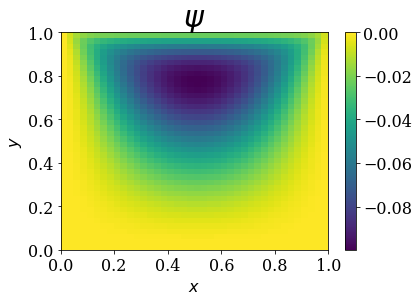

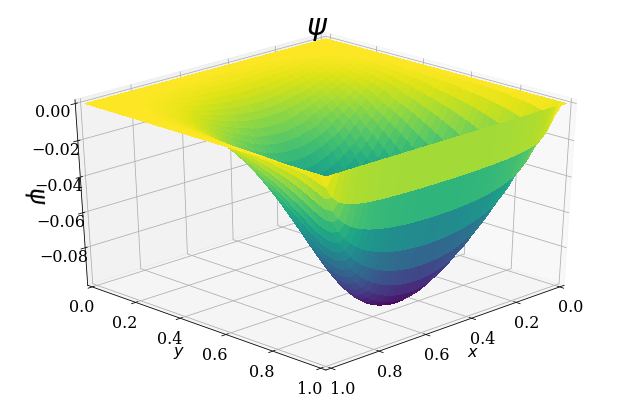

In [25]:
w2,psi2,iterations2,omega = Stokes_SOR(w0.copy(),psi0.copy())
print("Nombre d'itérations pour la méthode de Stokes SOR: {} avec omega = {}".format(iterations2, omega))
plot_2D(psi2)
plot_3D(x,y,psi2)

En effet, il ne suffit que de 730 itérations à SOR pour converger alors qu'il en faut 2118 à Gauss-Seidel. La méthode est très efficace, et elle est très rapide en plus : seulement 13.2 ms pour l'effectuer. Cest la meilleur méthode pour le moment.

La valeur maximale de |$\psi$| est :

In [26]:
numpy.max(numpy.abs(psi2[:]))

0.099845118464617438

La valeur maximale de |$\omega$| est :

In [27]:
numpy.max(numpy.abs(w2[:]))

120.0

In [28]:
numpy.max(numpy.abs(w2[:,1:-1]))

78.192661202771632

In [29]:
psi2[32,::8]

array([ 0.        , -0.05747872, -0.09442315, -0.09442315, -0.05747872,  0.        ])

La méthode indique les bons résultats.

## IV. Méthode de Steepest Descent

La méthode de Steepest Descent demande l'introduction d'un nouveau terme, le résiduel qui va nous donner la direction dans laquelle nous devrons itérer nos valeurs de $\omega$. C'est en fait une correction sur les valeurs calculées pour satisfaire à l'équation :

$$\nabla \omega^2 = 0$$ 


qui devient alors : 
\begin{equation}
{\bf r^k} + A \bf \omega^k = 0
\end{equation} avec A= $\nabla^2$ 

\begin{equation}
\nabla^2 \omega^k = 4\omega^k_{i,j} - \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation} pour notre cas ( notons que le terme de source est toujours nul).


Nous devons d'abord initialiser la première valeur de $r$ et itérer alors dessus. Ensuite, dans cette méthode le choix que le $kème$ pas et les $k+1ième$ pas soient orthogonaux impose un facteur $\alpha$ :

\begin{align}\alpha = \frac{{\bf r}^k \cdot {\bf r}^k}{A{\bf r}^k \cdot {\bf r}^k}.
\end{align}

Et nous obtenons finalement l'itération suivante sur $\omega$:

$${\bf \omega}^{k+1}={\bf \omega}^k + \alpha {\bf r}^k$$

In [30]:
def steepest_descent_2d(w,psi):

    r = numpy.zeros((ny,nx)) # residual
    Ar = numpy.zeros((ny,nx)) # to store result of matrix multiplication
    
    l2_norm1_w = 1
    l2_norm1_psi = 1
    iterations = 0
    
    # Iterations
    while l2_norm1_w > l1_target or l2_norm1_psi > l1_target :

        wd = w.copy()
        psid = psi.copy()
        
        r[1:-1,1:-1] = 4*wd[1:-1,1:-1] - wd[1:-1,2:] - wd[1:-1,:-2] - wd[2:, 1:-1] - wd[:-2, 1:-1]
        Ar[1:-1,1:-1] = -4*r[1:-1,1:-1]+r[1:-1,2:]+r[1:-1,:-2] + r[2:, 1:-1] + r[:-2, 1:-1]

        rho = numpy.sum(r*r)
        sigma = numpy.sum(r*Ar)
        alpha = rho/sigma

        w = wd + alpha*r
        
        psi[1:-1,1:-1] = 1./(2.*(dx**2 + dy**2)) * ((psi[2:,1:-1]+psi[:-2,1:-1])*dy**2 +\
                                (psi[1:-1,2:] + psi[1:-1,:-2])*dx**2 + w[1:-1,1:-1]*dx**2*dy**2)

        l2_norm_w =  numpy.abs(w - wd)
        l2_norm1_w = numpy.sum(l2_norm_w)
        l2_norm_psi = numpy.abs(psi-psid)
        l2_norm1_psi = numpy.sum(l2_norm_psi)
        iterations += 1
        
        #Bound condition
        w[:,-1] = -1./(2.*dx**2) * (8.*psi[:,-2] - psi[:,-3])               #right
        w[:,0] = -1./(2.*dx**2) * (8.*psi[:,1] - psi[:,2])                  #left
        w[0,:] = -1./(2.*dy**2) * (8.*psi[1,:] - psi[2,:])                  #bottom
        w[-1,:] = -1./(2.*dy**2) * (8.*psi[-2,:] - psi[-3,:]) - 3./dy       #top

    return w,psi,iterations

In [31]:
%%timeit
steepest_descent_2d(w0.copy(),psi0.copy())

1 loop, best of 3: 6.03 s per loop


Nombre d itérations pour la méthode de Steepest Descent: 8574


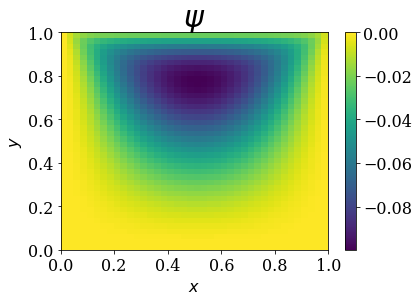

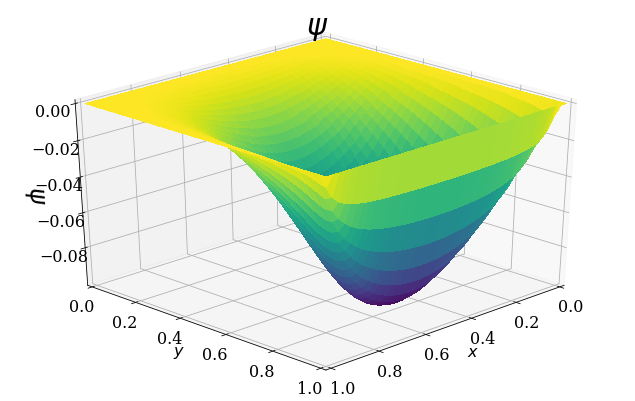

In [32]:
w3,psi3,iterations3 = steepest_descent_2d(w0.copy(),psi0.copy())
print('Nombre d itérations pour la méthode de Steepest Descent: {0:d}'.format(iterations3))
plot_2D(psi3)
plot_3D(x,y,psi3)

La valeur maximale de |$\psi$| est :

In [33]:
numpy.max(numpy.abs(psi3[:]))

0.099845171646043882

La valeur maximale de |$\omega$| est :

In [34]:
numpy.max(numpy.abs(w3[:]))

120.0

In [35]:
numpy.max(numpy.abs(w3[:,1:-1]))

78.192661235086632

In [36]:
psi3[32,::8]

array([ 0.        , -0.05747874, -0.09442319, -0.09442319, -0.05747874,  0.        ])

La méthode de Steepest descent fonctionne mais elle est la moins efficace de toute : en effet il lui faut 1.33 s pour faire tourner la boucle, et environ 8574 itérations en tout. Les autres méthodes vues auparavent sont toutes plus efficaces. 

## V. Conjugated Gradients

Remarque : nous avons essayé de réaliser la méthode des gradients conjugués, mais n'y sommes pas arrivé. Nous savons qu'il est nécessaire d'utiliser l'équation biharmonique, mais par faute de temps, nous n'avons pas pu l'approfondir.

In [37]:
@jit
def conjugate_gradient_2d(w,psi):    
    ny, nx = w.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    l2_norm_w = 1
    l2_norm_psi = 1
    iterations = 0
    
    r[1:-1,1:-1] = 4*w[1:-1,1:-1] - w[1:-1,2:] -\
                   w[1:-1,:-2] - w[2:, 1:-1] - w[:-2, 1:-1]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[1:-1,1:-1] = -4*d[1:-1,1:-1]+d[1:-1,2:]+d[1:-1,:-2]+d[2:, 1:-1] + d[:-2, 1:-1]
    sigma = numpy.sum(d*Ad)
    
    while l2_norm_w > l1_target or l2_norm_psi > l1_target:

        wk = w.copy()
        psik = psi.copy()
        rk = r.copy()
        dk = d.copy()

        alpha = rho/sigma

        w = wk + alpha*dk
        r = rk- alpha*Ad
        psi[1:-1,1:-1] = 1./(2.*(dx**2 + dy**2)) * ((psi[2:,1:-1]+psi[:-2,1:-1])*dy**2 +\
                                (psi[1:-1,2:] + psi[1:-1,:-2])*dx**2 + w[1:-1,1:-1]*dx**2*dy**2)
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1

        d = r + beta*dk
        Ad[1:-1,1:-1] = -4*d[1:-1,1:-1] + d[1:-1,2:] + d[1:-1,:-2] + \
            d[2:, 1:-1] + d[:-2, 1:-1]
        sigma = numpy.sum(d*Ad)

        l2_norm1_w =  numpy.abs(w - wk)
        l2_norm_w = numpy.sum(l2_norm1_w)
        l2_norm1_psi = numpy.abs(psi-psik)
        l2_norm_psi = numpy.sum(l2_norm1_psi)
        iterations += 1

        #Bound condition
        w[:,-1] = -1./(2.*dx**2) * (8.*psi[:,-2] - psi[:,-3])               #right
        w[:,0] = -1./(2.*dx**2) * (8.*psi[:,1] - psi[:,2])                  #left
        w[0,:] = -1./(2.*dy**2) * (8.*psi[1,:] - psi[2,:])                  #bottom
        w[-1,:] = -1./(2.*dy**2) * (8.*psi[-2,:] - psi[-3,:]) - 3./dy       #top

    return w,psi,iterations

## Conclusion

A travers ce module, nous avons pu étudier différentes manières pour résoudre l'écoulement de Stokes dans une cavité de forme carré grâce à plusieurs méthodes de relaxation. Nous pouvons conclure que parmis celles que nous avons réussis à implémenter, c'est la méthode de Stokes SOR qui se trouve être la plus efficace. Néanmoins, nous savons d'après la théorie que la méthode des gradients conjugués est également très efficace, mais nous n'avons malheureusement pas pu l'implémenter.